In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import gdown
import os
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
"""Transforming image into a tensor. If pixel values are between [0,255] ToTensor() will default normalise it into [0,1]"""
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [6]:
import os

dataset_path = '/kaggle/input/celeba/celeba'
print(os.listdir(dataset_path))


['list_eval_partition.txt', 'list_bbox_celeba.txt', 'identity_CelebA.txt', 'img_align_celeba', 'list_landmarks_align_celeba.txt', 'list_landmarks_celeba.txt', 'list_attr_celeba.txt']


In [7]:
"""Data for custom dataset class"""
# dataset_root = './celeba_data'
dataset_root = '/kaggle/input/celeba/celeba'

# Path to the images folder
images_folder = os.path.join(dataset_root, 'img_align_celeba')

# Path to the partition file (train/test/val split info)
partition_file = os.path.join(dataset_root, 'list_eval_partition.txt')

# Path to the attributes file (optional, if you need attributes)
attributes_file = os.path.join(dataset_root, 'list_attr_celeba.txt')

In [8]:
with open(partition_file, 'r') as f:
    partition_data = f.readlines()

partition_dict = {line.split()[0]: int(line.split()[1]) for line in partition_data}

# Separate into train, val, and test sets
train_images = [img for img, split in partition_dict.items() if split == 0]
val_images = [img for img, split in partition_dict.items() if split == 1]
test_images = [img for img, split in partition_dict.items() if split == 2]

In [9]:
class CelebADataset(Dataset):
    def __init__(self, images_list, images_folder, transform=None):
        self.images_list = images_list
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        img_name = self.images_list[idx]
        img_path = os.path.join(self.images_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, img_name


In [10]:
train_dataset = CelebADataset(train_images, images_folder, transform=transform)
val_dataset = CelebADataset(val_images, images_folder, transform=transform)
test_dataset = CelebADataset(test_images, images_folder, transform=transform)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,num_workers=4,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False,num_workers=4,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,num_workers=4,pin_memory=True)

In [12]:
for images, img_names in train_loader:
    print(f"Batch size: {images.size()}")
    print(f"Image names: {img_names[:5]}")
    break

Batch size: torch.Size([128, 3, 128, 128])
Image names: ['014119.jpg', '142699.jpg', '156710.jpg', '151024.jpg', '063942.jpg']


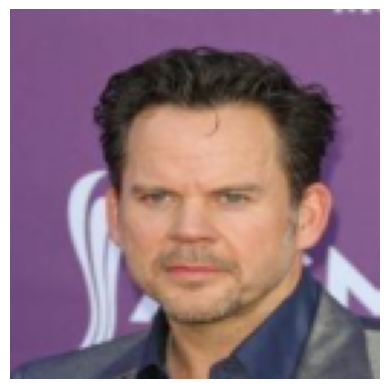

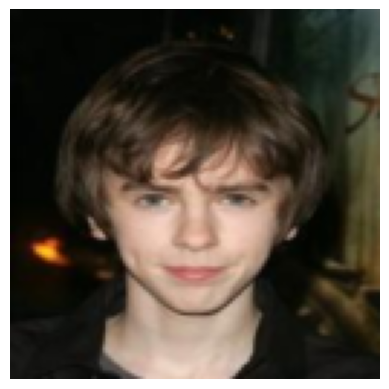

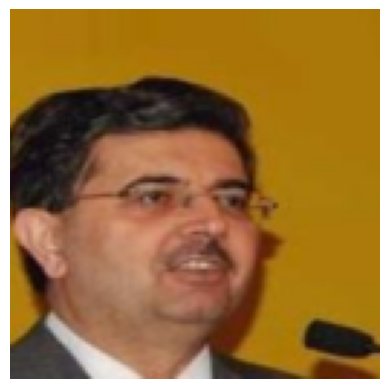

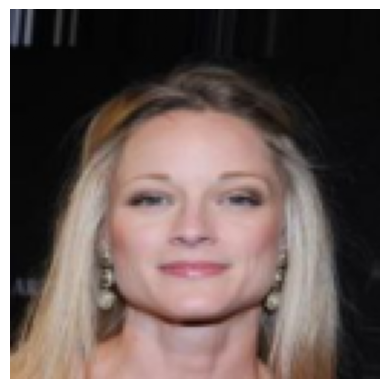

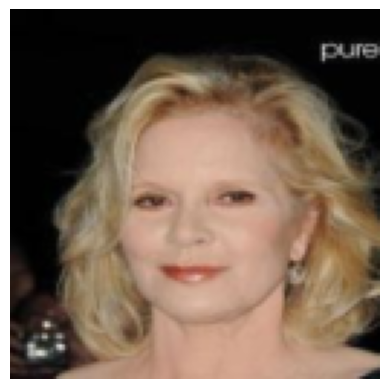

In [13]:
img,label = next(iter(train_loader))
# img[0]*255.0
for i in range(5):
    plt.figure()
    plt.imshow(img[i].permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

In [14]:
"""Data class"""
epochs = 50
beta = 0.1
batch_size = 128

In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Hout = ((Hin-Kernal+2*Padding)/Stride)+1
        # Input shape will be B,3,128,128 -> B,C,H,W
        self.c1 = nn.Conv2d(3,64,3,2,padding=1) # After this layer input will be B,64,64,64
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.LeakyReLU()
        self.c2 = nn.Conv2d(64,128,3,2,padding=1) # After this later input will be B,128,32,32
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.LeakyReLU()
        self.c3 = nn.Conv2d(128,128,3,2,padding=1) # After this layer input will be B,128,16,16
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.LeakyReLU()
        self.c4 = nn.Conv2d(128,128,3,2,padding=1) # After this layer input will be B,128,8,8
        self.bn4 = nn.BatchNorm2d(128)
        self.act4 = nn.LeakyReLU()
        self.c5 = nn.Conv2d(128,128,3,2,padding=1) # After this layer input will be B,128,4,4
        self.bn5 = nn.BatchNorm2d(128)
        self.act5 = nn.LeakyReLU()
        self.c6 = nn.Conv2d(128,128,3,2,padding=1) # After this layer input will be B,128,2,2
        self.bn6 = nn.BatchNorm2d(128)
        self.act6 = nn.LeakyReLU()
        self.flatten_layer = nn.Flatten(start_dim=1,end_dim=-1)
        self.z_mu = nn.Linear(128*2*2,200)
        self.z_logvar = nn.Linear(128*2*2,200)

    def forward(self,x):
        x = self.act1(self.bn1(self.c1(x)))
        x = self.act2(self.bn2(self.c2(x)))
        x = self.act3(self.bn3(self.c3(x)))
        x = self.act4(self.bn4(self.c4(x)))
        x = self.act5(self.bn5(self.c5(x)))
        x = self.act6(self.bn6(self.c6(x)))
        x = self.flatten_layer(x)
        z_mean = self.z_mu(x)
        z_logvar = self.z_logvar(x)
        return z_mean,z_logvar

In [16]:
class Sampling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,z_mean,z_logvar):
        batch_size,dim = z_mean.shape
        epsilon = torch.randn(batch_size,dim,device=z_mean.device)
        return z_mean + torch.exp(0.5*z_logvar)*epsilon


In [17]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(200,128*2*2)
        self.dbn1 = nn.BatchNorm1d(128*2*2)
        self.dact1 = nn.LeakyReLU()
        #self.reshape_layer = nn.Linear(128*2*2,(128,2,2)) # Now shape will B,128,2,2
        # Hout = (Hin-1)*stride -2*padding+kernel+output_padding
        self.ct1 = nn.ConvTranspose2d(128,128,kernel_size=3,stride=2,padding=1,output_padding=1) # After this layer B,128,4,4
        self.bn1 = nn.BatchNorm2d(128)
        self.act1 = nn.LeakyReLU()
        self.ct2 = nn.ConvTranspose2d(128,128,kernel_size=3,stride=2,padding=1,output_padding=1) # After this layer B,128,8,8
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.LeakyReLU()
        self.ct3 = nn.ConvTranspose2d(128,128,kernel_size=3,stride=2,padding=1,output_padding=1) # B,128,16,16
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.LeakyReLU()
        self.ct4 = nn.ConvTranspose2d(128,128,kernel_size=3,stride=2,padding=1,output_padding=1) # B,128,32,32
        self.bn4 = nn.BatchNorm2d(128)
        self.act4 = nn.LeakyReLU()
        self.ct5 = nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1) # B,64,64,64
        self.bn5 = nn.BatchNorm2d(64)
        self.act5 = nn.LeakyReLU()
        self.ct6 = nn.ConvTranspose2d(64,3,kernel_size=3,stride=2,padding=1,output_padding=1) # B,3,128,128
        #self.bn6 = nn.BatchNorm2d(3)
        # self.act6 = nn.LeakyReLU()
        self.act6 = nn.Sigmoid()

    def forward(self,x):
        x = self.dact1(self.dbn1(self.dense1(x)))
        x = x.view(-1,128,2,2)
        x = self.act1(self.bn1(self.ct1(x)))
        x = self.act2(self.bn2(self.ct2(x)))
        x = self.act3(self.bn3(self.ct3(x)))
        x = self.act4(self.bn4(self.ct4(x)))
        x = self.act5(self.bn5(self.ct5(x)))
        x = self.act6(self.ct6(x))
        return x

In [18]:
def KL_Divergence_Loss(z_mean,z_logvar):
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean**2 - torch.exp(z_logvar), dim=1)
    # we dont want to keepdim=true because we just want B not B,1
    kl_loss = kl_loss.mean()
    return kl_loss

In [19]:
criterion = nn.MSELoss(reduction='sum')

In [20]:
criterion = criterion.to(device) if hasattr(criterion, "to") else criterion

In [21]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
sampling_layer = Sampling().to(device)

In [22]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling_layer = sampling_layer

    def forward(self,x):
        z_mean,z_logvar = self.encoder(x)
        loss = KL_Divergence_Loss(z_mean,z_logvar)
        z_sample = self.sampling_layer(z_mean,z_logvar)
        out = self.decoder(z_sample)
        return loss,out

In [23]:
model = AutoEncoder().to(device)

In [24]:
for p in model.parameters():
    p.requires_grad = True

In [25]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total params are",total_params)

total params are 1643539


In [26]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.AdamW(model.parameters(),lr=0.01,weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1,threshold=0.001)

In [27]:
train_losses = []
#train_accuracies = []
test_losses = []
#test_accuracies = []
val_losses = []

In [28]:
checkpoint_dir = '/kaggle/working/v1-checkpoints'  # This will save in Kaggle's working directory
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

def save_checkpoint(model, optimizer, epoch, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)

In [29]:

for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss = 0
    total_kl_loss = 0
    total_rec_loss = 0
    num_batches = len(train_loader)  # Total number of batches in the training set

    # Train loop
    for xb, yb in train_loader:
        optimizer.zero_grad(set_to_none=True)

        # Move data to the device
        xb = xb.to(device)

        # Forward pass through the model
        kl_loss, outs = model(xb)
        outs = outs.to(device)

        # Calculate reconstruction loss and total KL loss
        reconstructed_loss = criterion(xb, outs)
        reconstructed_loss = reconstructed_loss/batch_size

        total_kl_loss += kl_loss.item()
        total_rec_loss += reconstructed_loss.item()

        # Calculate total loss (including KL divergence)
        loss = reconstructed_loss + beta * kl_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the total loss for the epoch
        total_loss += loss.item()

    # Compute the average losses
    avg_train_loss = total_loss / num_batches
    avg_rec_loss = total_rec_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches

    # Validation loop
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # No gradient calculation during validation
        for xb, yb in val_loader:
            reconstructed_loss = 0
            xb = xb.to(device)
            kl_loss, outs = model(xb)
            outs = outs.to(device)

            # Calculate reconstruction loss and total KL loss for validation
            reconstructed_loss = criterion(xb, outs)
            reconstructed_loss = reconstructed_loss/batch_size
            val_loss = reconstructed_loss + beta * kl_loss

            # Accumulate validation loss
            total_val_loss += val_loss.item()

    # Compute average validation loss
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print statistics for the current epoch
    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Rec Loss: {avg_rec_loss:.4f}, "
          f"KL Loss: {avg_kl_loss:.4f}")

    # Print learning rate
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    checkpoint_filename = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
    save_checkpoint(model, optimizer, epoch, avg_train_loss, checkpoint_filename)

    # Scheduler step with validation loss
    scheduler.step(avg_val_loss)


Epoch 1/50 - Train Loss: 1222.2375, Validation Loss: 770.5295, Rec Loss: 1159.4829, KL Loss: 627.5452
Learning Rate: 0.010000
Epoch 2/50 - Train Loss: 646.9990, Validation Loss: 605.4711, Rec Loss: 612.3970, KL Loss: 346.0198
Learning Rate: 0.010000
Epoch 3/50 - Train Loss: 561.4296, Validation Loss: 565.9492, Rec Loss: 526.1332, KL Loss: 352.9641
Learning Rate: 0.010000
Epoch 4/50 - Train Loss: 505.8593, Validation Loss: 488.4121, Rec Loss: 470.4968, KL Loss: 353.6247
Learning Rate: 0.010000
Epoch 5/50 - Train Loss: 475.0488, Validation Loss: 456.0411, Rec Loss: 439.2263, KL Loss: 358.2248
Learning Rate: 0.010000
Epoch 6/50 - Train Loss: 452.3812, Validation Loss: 450.8607, Rec Loss: 416.1446, KL Loss: 362.3658
Learning Rate: 0.010000
Epoch 7/50 - Train Loss: 435.2254, Validation Loss: 426.9503, Rec Loss: 398.4067, KL Loss: 368.1876
Learning Rate: 0.010000
Epoch 8/50 - Train Loss: 419.4676, Validation Loss: 458.7791, Rec Loss: 381.8672, KL Loss: 376.0049
Learning Rate: 0.010000
Epoch 

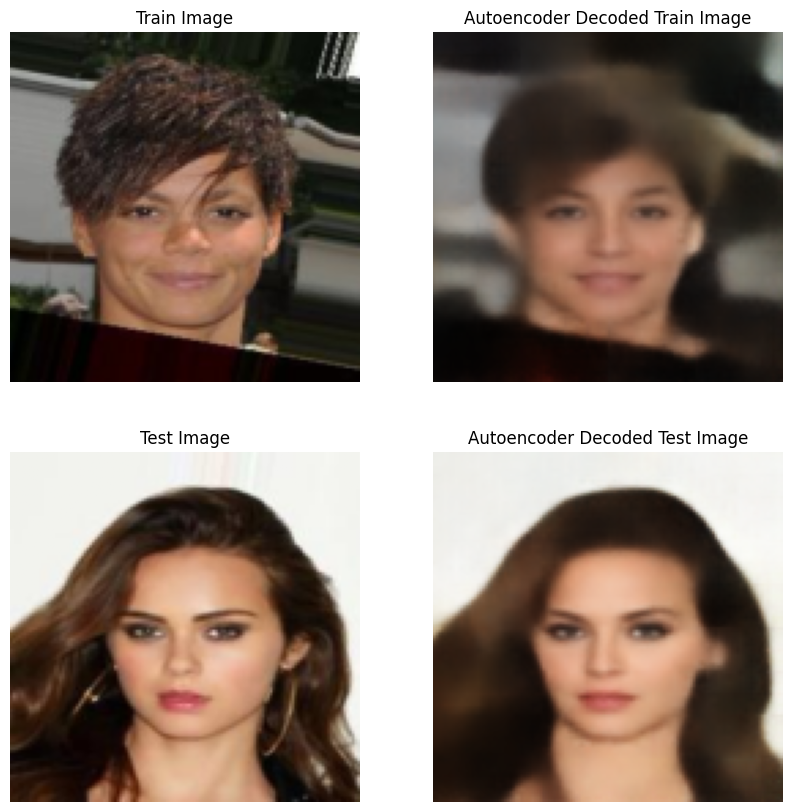

In [43]:
model.eval()

btrain_img, _ = next(iter(train_loader))  # Get a batch of train images
btest_img, _ = next(iter(test_loader))  # Get a batch of test images

btrain_img = btrain_img.to(device)
btest_img = btest_img.to(device)

_, train_out = model(btrain_img[0].unsqueeze(0))  # Process a single image
train_out = train_out.cpu().detach().squeeze(0).permute(1, 2, 0).numpy()  # Convert to (H, W, C)

_, test_out = model(btest_img[i].unsqueeze(0))  # Process a single image
test_out = test_out.cpu().detach().squeeze(0).permute(1, 2, 0).numpy()  # Convert to (H, W, C)

plt.figure(figsize=(10, 10))

# Plot the original train image
plt.subplot(2, 2, 1)
plt.imshow(btrain_img[0].permute(1, 2, 0).cpu().numpy())  # Convert from (C, H, W) to (H, W, C)
plt.title("Train Image")
plt.axis('off')

# Plot the autoencoder decoded train image
plt.subplot(2, 2, 2)
plt.imshow(train_out)
plt.title("Autoencoder Decoded Train Image")
plt.axis('off')

# Plot the original test image
plt.subplot(2, 2, 3)
plt.imshow(btest_img[i].permute(1, 2, 0).cpu().numpy())  # Convert from (C, H, W) to (H, W, C)
plt.title("Test Image")
plt.axis('off')

# Plot the autoencoder decoded test image
plt.subplot(2, 2, 4)
plt.imshow(test_out)
plt.title("Autoencoder Decoded Test Image")
plt.axis('off')

# Show the plot
plt.show()

In [42]:
i = 21

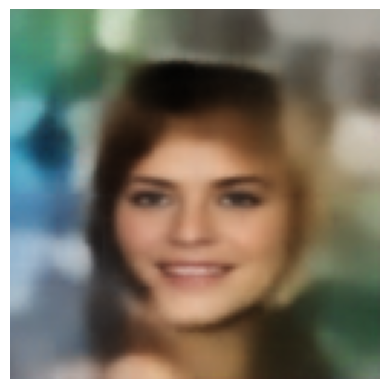

In [52]:
model.eval()
zsample = torch.randn(1, 200).to(device)  

with torch.no_grad():
    gen_img = decoder(zsample)
    gen_img = gen_img.cpu().detach().numpy().squeeze(0)
    gen_img = gen_img.transpose(1, 2, 0)
    plt.imshow(gen_img)
    plt.axis('off')  # Turn off axis labels
    plt.show()

In [53]:
torch.save(model, "/kaggle/working/final_model.pth")

In [54]:
torch.save(model.state_dict(), "/kaggle/working/final_model_weights.pth")